# Риск попадания в ДТП

<div class="pull-right">

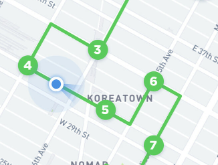

</div>


**Описание проекта**

Каршеринговая компании.\
Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.\
Есть исторические данные каршеринговой компании одного из регионов.
Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.\
Целевой признак 'at_fault' в таблице 'parties'.



**Исходные материалы (ER-диаграмма базы данных):**

* collisions (информация о происшествиях);
* Parties (описание участников происшествия);
* Vehicles (Описание автомобиля).
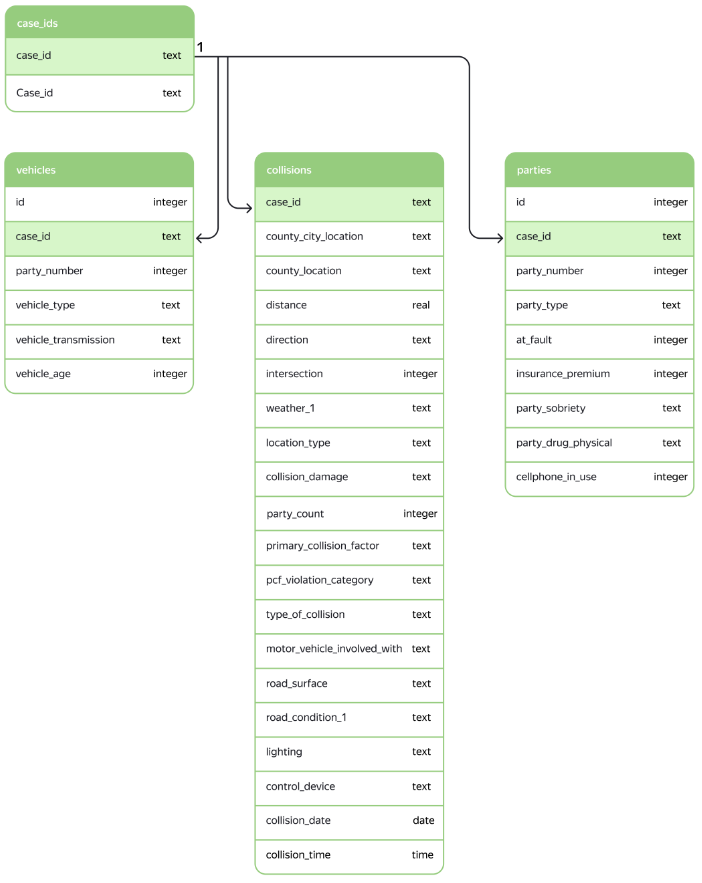

## Подключение к базе. Загрузка таблиц sql

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import random
import phik
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool, cv
import re

In [2]:
pd.set_option('display.max_columns', None) # установка для вывода всех столбцов таблицы на экран

In [3]:
# инициализация генератора случайных чисел
random.seed(10) 
np.random.seed(10)

In [4]:
# создание соединения с базой данных

db_config = {
    'user': 'praktikum_student',
    'pwd' : 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port':  6432,
    'db'  : 'data-science-vehicle-db'
             }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'])

engine = create_engine(connection_string)

In [5]:
# смотрим, какие есть таблицы для проекта
query = '''
SELECT *
FROM   pg_catalog.pg_tables
WHERE  pg_catalog.pg_tables.schemaname = 'public'
'''

pd.read_sql_query(query, con = engine)['tablename']

0    collisions
1      case_ids
2       parties
3      vehicles
Name: tablename, dtype: object

In [6]:
%%time
# загрузка таблиц SQL и создание pandas-dataframe'ов 
for t in ('collisions', 'parties', 'vehicles', 'case_ids'):
    exec(t+"= pd.read_sql_query('SELECT * FROM '+ t, con=engine)")

CPU times: total: 29.9 s
Wall time: 53.1 s


## Первичное исследование таблиц

* Всего 4 таблицы. В задании отстутсвует описание таблицы *case_ids*; на ER-диаграмме присутствует.
* Общий ключ для связи таблиц - *case_id*.

### collisions

In [7]:
collisions.head(3)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


In [8]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

In [9]:
def gaps(df):
    '''выводит сумму и долю пропусков; на входе dataframe'''
    display(pd.DataFrame(df.isna().sum(),  columns = ['sum']).join(
            pd.DataFrame(df.isna().mean(), columns = ['share'])).
            style.format({'sum':'{:.0f}', 'share':'{:.2f}'}).background_gradient())

In [10]:
gaps(collisions)  # сумма и доля пропусков

,sum,share
case_id,0,0.00
county_city_location,0,0.00
county_location,0,0.00
distance,0,0.00
direction,340642,0.24
intersection,12219,0.01
weather_1,7259,0.01
location_type,881221,0.63
collision_damage,0,0.00
party_count,0,0.00


In [11]:
collisions.duplicated().sum()  # кол-во полных дубликатов

0

* Таблица содержит набор данных согласно заданию.
* Признак *control_device* в описании задания называется *CONTROL_CONDITION_1*; в ER-диаграмме - *control_device*.
* Признак *primary_collision_factor* в описании - *PRIMARY_COLL_FACTOR*; в ER-диаграмме - *primary_collision_factor*.
* *case_id*, *county_city_location*	 - object-тип, странно что не числовой.
* Много пропусков в *location_type* (63%), *direction* (24%).
* Полных дубликатов нет.

### parties

In [12]:
parties.head(3)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0


In [13]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


In [14]:
gaps(parties) # сумма и доля пропусков

,sum,share
id,0,0.00
case_id,0,0.00
party_number,0,0.00
party_type,3622,0.00
at_fault,0,0.00
insurance_premium,405402,0.15
party_sobriety,73955,0.03
party_drug_physical,2320120,0.84
cellphone_in_use,511637,0.19


In [15]:
parties.duplicated().sum() # кол-во полных дубликатов

0

* Таблица содержит набор данных согласно заданию.
* *case_id* - object-тип, странно что не числовой.
* Много пропусков в *party_drug_physical* (84%), *cellphone_in_use* (19%), *insurance_premium* (15%).
* Полных дубликатов нет.

### vehicles

In [16]:
vehicles.head(3)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0


In [17]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [18]:
gaps(vehicles) # сумма и доля пропусков

,sum,share
id,0,0.00
case_id,0,0.00
party_number,0,0.00
vehicle_type,0,0.00
vehicle_transmission,23659,0.02
vehicle_age,24582,0.02


In [19]:
vehicles.duplicated().sum() # кол-во полных дубликатов

0

* Таблица содержит набор данных согласно заданию.
* *case_id* - object-тип, странно что не числовой.
* Пропусков немного.
* Полных дубликатов нет.

### case_ids

In [20]:
case_ids.head(3)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021


In [21]:
case_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


In [22]:
gaps(case_ids)   # сумма и доля пропусков

,sum,share
case_id,0,0.00
db_year,0,0.00


In [23]:
case_ids.duplicated().sum() # кол-во полных дубликатов

0

* В задании не дано описание этой таблицы; присутствует в ER-диаграмме; вероятно указан год создания базы данных.
* *case_id*, *db_year* - object-тип, странно что не числовой.
* Пропусков нет.
* Полных дубликатов нет.

##  Статистический анализ факторов ДТП

### ежемесячная авариность   
<a id= 'month_distribution'></a>

In [24]:
query = '''
SELECT DATE_TRUNC('month', collision_date)::date AS month,
       COUNT (*)
FROM collisions
GROUP BY month
ORDER BY month
'''

accidents_per_month = pd.read_sql_query(query, con = engine)

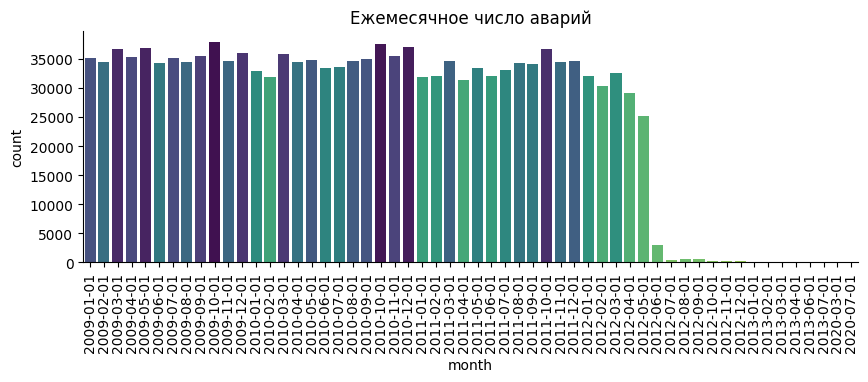

In [25]:
pal = sns.color_palette("viridis", len(accidents_per_month))
rank = accidents_per_month['count'].argsort().argsort() 

plt.figure(figsize=(10,3))
ax=sns.barplot(data=accidents_per_month, y='count', x='month', palette=np.array(pal[::-1])[rank])
ax.tick_params(axis='x', labelrotation=90); ax.set_title('Ежемесячное число аварий'); sns.despine(); plt.show()

Начиная с мая 2012г. данные подозрительно резко уменьшаются. Скорее всего, произошла техническая ошибка и эти данные недостоверны.\
Чтобы определить наиболее аварийный месяц, возьмём информацию только вплоть до апреля 2012г. и посчитаем среднее месячное значение.

In [26]:
query = '''

SELECT EXTRACT(MONTH FROM month) AS only_month_int,
       TO_CHAR(month, 'month') AS only_month,
       AVG(count)
FROM (SELECT DATE_TRUNC('month', collision_date)::date AS month,
             COUNT (*)
      FROM collisions
      GROUP BY month
      ORDER BY month) AS pre_table
WHERE month < '2012-05-01'
GROUP BY only_month_int, only_month
'''

accidents_per_month = pd.read_sql_query(query, con = engine)

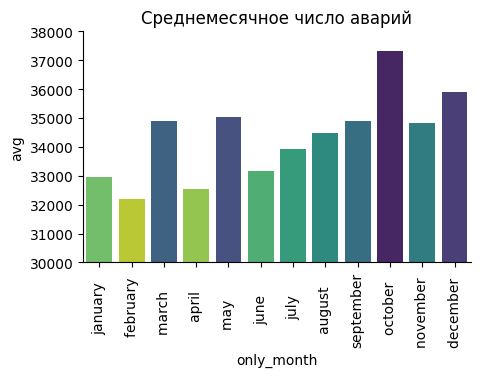

In [27]:
pal = sns.color_palette("viridis", len(accidents_per_month))
rank = accidents_per_month['avg'].argsort().argsort() 

plt.figure(figsize=(5,3)); plt.ylim(30000,38000)
ax=sns.barplot(data=accidents_per_month, y='avg', x='only_month', palette=np.array(pal[::-1])[rank])
ax.tick_params(axis='x', labelrotation=90); ax.set_title('Среднемесячное число аварий'); sns.despine(); plt.show()

Наблюдается плавно изменяющаяся закономерность с выбросами в марте, мае и октябре.\
Наибольшее количество аварий в осенне-зимние месяцы с сентября по декабрь. Пик аварийности в октябре. Может быть связано с первым гололёдом; водители ментально не успели перестроиться на более осторожное вождение и не поменяли колёса на зимние.

### аналитические задачи для команды

По всем задачам сделать вывод.

**Задача 1**

Влияет ли тип кузова на серьёзность повреждения транспортного средства; какой тип кузова наиболее подвержен воздействию аварии, какой меньше?

Порядок решения:
* сделать SQL запрос в таблицы vehicles, collisions для получения результата с полями: vehicle_type, collision_damage, count; произвести группировку категориальных данных;
* построить столбчатую диаграмму зависимости серьёзности повреждения от типа кузова; по горизонтальной оси тип кузова, по вертикальной - количества случаев определённого типа серьёзности повреждения.

In [28]:
query = '''
SELECT vehicle_type,
       collision_damage,
       COUNT(collision_damage)
FROM (SELECT case_id,
             vehicle_type
      FROM   vehicles) AS v
INNER JOIN (SELECT case_id,
                   collision_damage
            FROM   collisions) AS c ON v.case_id = c.case_id
GROUP BY vehicle_type, collision_damage
'''
vehicle_type_vs_damage = pd.read_sql_query(query, con = engine)

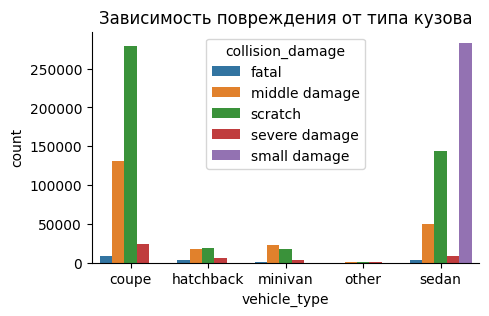

In [29]:
plt.figure(figsize=(5,3))
sns.barplot(data=vehicle_type_vs_damage, x='vehicle_type', y='count', hue='collision_damage').\
    set_title('Зависимость повреждения от типа кузова')
sns.despine(); plt.show()

Больше всего происшествий с купе и седанами, скорее всего, из-за того, что их больше в эксплуатации (а не из-за того, что они более аварийные).\
Чтобы ответить на вопрос, какой тип кузова более опасен (чаще попадапет в аварию) необходимо выяснять доли от общего количества эксплуатируемых типов. Такой информации нет.
У седанов почему-то введена дополнительная градация - small damage.\
Очерёдность типов повреждения у всех типов кузова одинаковая, кроме минивена (больше всего средних повреждений, а не царапин).

**Задача 2**

Действительно ли в машинах с ручной коробкой передач реже установлены hands free?

Порядок решения:
* SQL запрос; воспользоваться таблицами *vehicles*, *parties*; на выходе таблица с количеством машин с hands free у каждого типа трансмиссии;
* построить столбчатую диаграмму; по оси x - *vehicle_transmission*, по оси y - количество аварий с машинами, оборудованными hands free.

In [30]:
query = '''
SELECT vehicle_transmission,
       COUNT(*)
FROM (SELECT case_id,
             vehicle_transmission
      FROM vehicles
      WHERE vehicle_transmission IN ('auto', 'manual')) AS v
INNER JOIN (SELECT case_id
            FROM parties
            WHERE cellphone_in_use = 1) AS p ON v.case_id = p.case_id
GROUP BY vehicle_transmission
'''
transmission_vs_cellphone = pd.read_sql_query(query, con = engine)

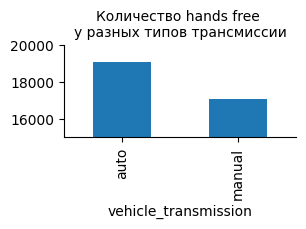

In [31]:
transmission_vs_cellphone.plot(kind='bar', x='vehicle_transmission', y='count', 
                               title='Количество hands free \nу разных типов трансмиссии', figsize=(3,1.2), 
                               ylim=(15000,20000), legend=False).title.set_size(10)
sns.despine()

В машинах с ручной коробкой передач реже установлено оборудование hands free.\
Связано с тем, что машины более позднего года выпуска чаще используют АКП, и в них чаще устанавливают система для более безопасного вождения, в том числе hands free.\
Тем не менее разница не слишком большая.

**Задача 3**

Прослеживается ли зависимость между типом нарушения и возрастом автомобиля?\
Возрастные автомобили реже попадают в аварии из-за превышения скорости?

Порядок решения:
* SQL запрос; использовать таблицы *vehicles*, *collisions*; признак *vehicle_age* категоризировать с интервалом 3 года - [0-3],(3-6], (6-9], ... , (21-&#8734;);\
сгруппировать по *pcf_violation_category* и категоризированному *vehicle_age*, посчитать количества;
* построить тепловую карту: по оси x - *pcf_violation_category*, по y - категоризированный c интервалом 3 года *vehicle_age*; значения в карте - количество типа нарушения в данном диапазоне.

In [32]:
query = '''

SELECT pcf_violation_category, 
       age,
       COUNT (*)
FROM   (SELECT case_id,
               CASE
                   WHEN vehicle_age <=3  THEN '[0-3]'
                   WHEN vehicle_age <=6  THEN '(3-6]'
                   WHEN vehicle_age <=9  THEN '(6-9]'
                   WHEN vehicle_age <=12 THEN '(9-12]'
                   WHEN vehicle_age <=15 THEN '(12-15]'
                   WHEN vehicle_age <=18 THEN '(15-18]'
                   WHEN vehicle_age <=21 THEN '(18-21]'
                   ELSE '(21-∞)'
               END AS age
        FROM   vehicles
        WHERE  vehicle_age IS NOT NULL) AS v
INNER JOIN (SELECT case_id,
                   pcf_violation_category
            FROM   collisions
            WHERE  pcf_violation_category IS NOT NULL) AS c ON v.case_id = c.case_id
GROUP BY pcf_violation_category, age
'''
age_vs_violation = pd.read_sql_query(query, con = engine)

In [33]:
# переформатирование в сводную таблицу
age_vs_violation = age_vs_violation.pivot(index='age', 
                                          columns='pcf_violation_category', 
                                          values='count').reindex(
                   index=['(21-∞)', '(18-21]', '(15-18]', '(12-15]', '(9-12]', '(6-9]', '(3-6]', '[0-3]'])

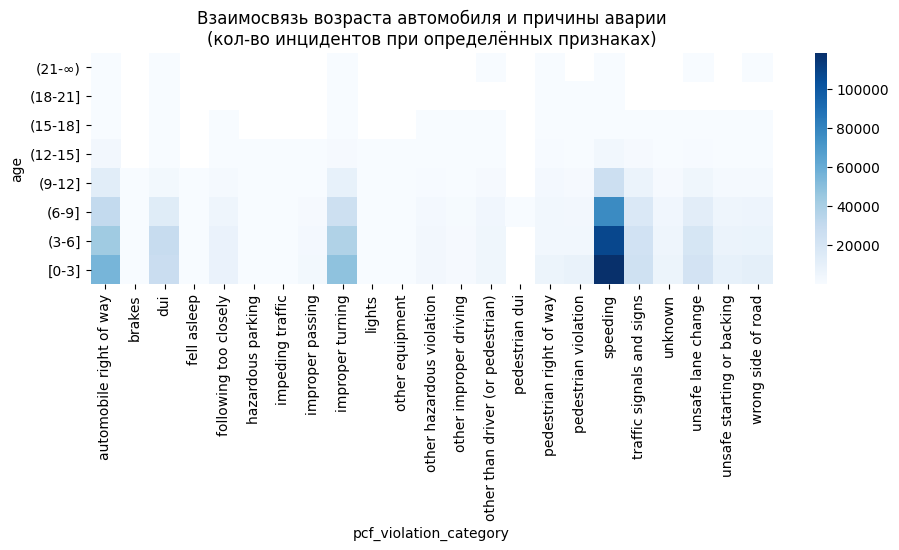

In [34]:
plt.figure(figsize=(11,3))
sns.heatmap(age_vs_violation, cmap='Blues')
plt.title('Взаимосвязь возраста автомобиля и причины аварии\n(кол-во инцидентов при определённых признаках)'); plt.show()

* Однозначно прослеживается, что более новые автомобили чаще попадают в аварии по причине превышения скорости. Есть возможность и желание владельца показать класс машины.
* Также прослеживается, что нарушения связанные с правом проезда, езды в алкогольном опьянении и неправильным поворотом чаще присущи более новым автомобилям;\
скорее всего связано, что новые машины приобретают молодые люди без опыта вождения и с заниженным пониманием социальной ответственности перед окружающими.

**Задача 4**

Верно ли, что в ночное время происходит больше аварий с водителями в алкогольном опьянении?

Порядок решения:
* SQL запрос применить к таблицам parties, collisions чтобы получить таблицу только со временем аварии, произошедшей по вине алкогольного опьянения; время обрезать до значения часов;
* построить гистограмму числа аварий по причине алкогольного опьянения водителя в диапазоне суток.

In [35]:
query = '''
WITH
parties_drunken AS (SELECT case_id
                    FROM   parties
                    WHERE  party_sobriety LIKE '%%had been drinking%%'),
time AS            (SELECT case_id,
                           EXTRACT(HOUR FROM collision_time) AS hours
                    FROM   collisions)
SELECT hours
FROM   parties_drunken
INNER JOIN time ON parties_drunken.case_id = time.case_id
'''
sobriety_vs_time = pd.read_sql_query(query, con = engine)

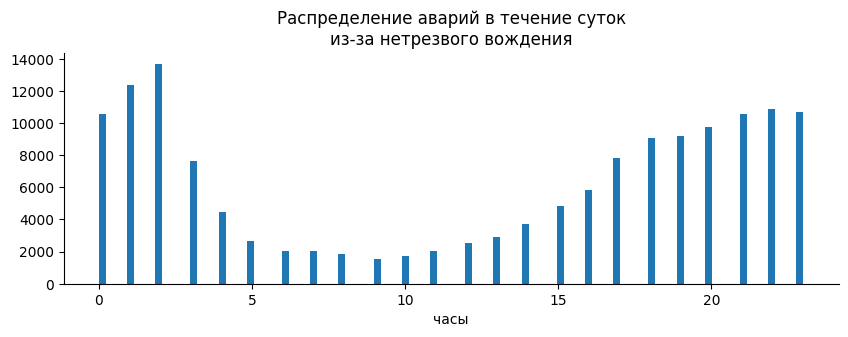

In [36]:
sobriety_vs_time['hours'].hist(bins=100, figsize=(10,3), grid=False).\
                          set_title('Распределение аварий в течение суток\nиз-за нетрезвого вождения')
plt.xlabel('часы'); sns.despine()

Всплеск аварийного вождения из-за алкогольного опьянения приходится на вечернее и ночное время суток: с 18:00 до 3 ночи. Пик в 2 ночи.

**Задача 5**

В какой месяц водители чаще попадают в аварию из-за усталости/сонливости?

Порядок решения:
* SQL запрос к таблицам collisions, parties; рассмотреть только данные которые не вызывают сомнения - до апреля (включая) 2012г. (см. выше диаграмму распределения аварийности по месяцам в п.3.1); на выходе таблица с названием месяца и среднемесячным числом аварий за наблюдаемые годы;
* сделать столбчатую диаграмму; по оси x - месяц, по оси y - среднемесячное число аварий по причине усталости или сонливости.

In [37]:
query = '''
WITH
pre_table AS (SELECT      year, 
                          month_num, 
                          month,
                          COUNT(*)
              FROM       (SELECT case_id
                          FROM   parties
                          WHERE  party_drug_physical = 'sleepy/fatigued') AS p
              INNER JOIN (SELECT case_id,
                          EXTRACT(YEAR FROM collision_date) AS year,
                          EXTRACT(MONTH FROM collision_date) AS month_num,
                          TO_CHAR(collision_date, 'month') AS month
                          FROM   collisions
                          WHERE  collision_date < '2012-05-01') AS c ON p.case_id = c.case_id
              GROUP BY year, month_num, month)
SELECT   month_num, 
         month,
         AVG(count)
FROM     pre_table
GROUP BY month_num, month
ORDER BY month_num
'''
sleepy_vs_month = pd.read_sql_query(query, con = engine)

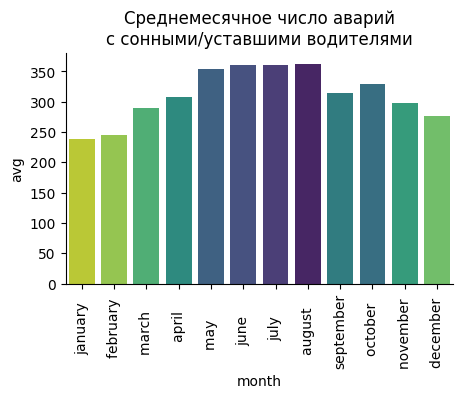

In [38]:
pal = sns.color_palette("viridis", len(sleepy_vs_month))
rank = sleepy_vs_month['avg'].argsort().argsort() 

plt.figure(figsize=(5,3))
ax=sns.barplot(data=sleepy_vs_month, y='avg', x='month', palette=np.array(pal[::-1])[rank])
ax.tick_params(axis='x', labelrotation=90); ax.set_title('Среднемесячное число аварий\nc сонными/уставшими водителями')
sns.despine(); plt.show()

Больше всего аварий по причине сонливости или усталости водителя в летние месяцы.\
Одна из возможных причин - летом больше машин, больше аварий, больше аварий с сонными водителями. Но эта гипотеза не подтверждается, так как максимальная аварийность в зимние месяцы (см. выше п.3.1).

Почему же всё таки "спящих водителей" больше летом - сложный вопрос, требующий дополнительного анализа.

**Задача 6** <a id= 'north'></a>

Есть ли зависимость между тем, произошла авария утром/вечером и в каком направлении двигался виновник дтп?\
Подразумевается ослепление низким солнцем. Гипотеза: большее число аварий при движении вечером на Запад, а утром на Восток.

Порядок решения:
* SQL запрос к таблицам collisions, parties; сгруппировать данные по времени суток: утро [5,11), день [11,17), вечер [17,23), ночь [23,5); выбрать только аварии/машины виновников; на выходе таблица с числом аварий и с группировкой по времени суток и направлению движения;
* Построить тепловую карту: по оси x - время суток, по оси y - направление движения, значения - количество аварий виновников.

In [39]:
query = '''
SELECT time_of_day, 
       direction,
       COUNT(*)
FROM   (SELECT case_id
        FROM   parties
        WHERE  at_fault = 1
          AND  party_type = 'car') AS p
INNER JOIN (SELECT case_id,
                   direction,
                   CASE
                       WHEN EXTRACT(HOUR FROM collision_time) <  5 
                         OR EXTRACT(HOUR FROM collision_time) = 23 THEN 'night'
                       WHEN EXTRACT(HOUR FROM collision_time) < 11 THEN 'morning'
                       WHEN EXTRACT(HOUR FROM collision_time) < 17 THEN 'day'
                       WHEN EXTRACT(HOUR FROM collision_time) < 23 THEN 'evening'
                   END AS time_of_day
            FROM  collisions
            WHERE direction IS NOT NULL
              AND collision_time IS NOT NULL) AS c ON p.case_id=c.case_id
GROUP BY time_of_day, direction 
'''
direction_vs_time = pd.read_sql_query(query, con = engine)

In [40]:
# формирование сводной таблицы, уменьшение размерности, округление
direction_vs_time = (direction_vs_time.pivot(index='direction', columns='time_of_day', values='count').\
                                       reindex(columns=['morning','day','evening','night'], 
                                               index=['north','south','west','east'])\
                     /1000).round()

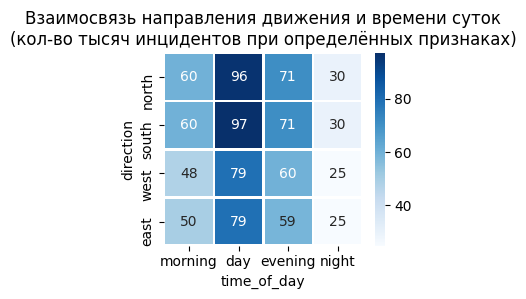

In [41]:
plt.figure(figsize=(3.2,2.5))
sns.heatmap(direction_vs_time, cmap='Blues', linewidth = 1, annot=True)
plt.title('Взаимосвязь направления движения и времени суток\n(кол-во тысяч инцидентов при определённых признаках)'); plt.show()

* Гипотеза с большим числом аварий при движении на солце имеет очень слабое подтверждение. Действительно утром в восточном направлении аварий на 4% больше, чем в западном. А вечером в западном направлении аварий на 2% больше чем в восточном.
Разница незначительная и может являться просто погрешностью вычисления. Гипотеза не подтверждается.
* Аварий при "вертикальном" движении (север/юг) на 20% больше числа аварий в "горизонтальном" (запад/восток) движении.\
Скорее всего связано с тем, что вертикальный трафик больше горизонтального; и как следствие больше аварий. Т.е., например, спальные районы и офисы находятся по вертикали.
Для проверки этого предположения нужны данные по общему трафику, чтобы определить долю аварий. Такой информации нет.

## Анализ данных

### Подготовка набора данных

Подготовка набора данных на основе первичного предположения заказчика:
- тип виновника — только машина (car);
- аварии с царапинами (scratch) не учитывать;
- использовать данные только за 2012год, как наиболее свежие.

Все представленные в таблицах признаки могут в той или иной степени влиять на целевой признак (виновен / невиновен).\
В таблицах есть факторы, которые известны перед стартом автомобиля, а есть признаки, зафиксированные после произошедшей аварии.\
Согласно заданию заказчика - определить произойдёт ли дтп перед началом движения, нам необходима только 1-ая группа признаков.\
Тем не менее проведём полный анализ всех имеющихся в нашем распоряжении признаков. Это позволит представить полную картину по датасету, увидеть взаимосвязь между всеми признаками.

Заключение, какие данные нам известны перед стартом, а какие после аварии, находится ниже в разделе [4.3 Корреляция признаков](#corr).

Окончательный отбор признаков для ML сделаем позднее в соответсвующем разделе, полагаясь на матрицу корреляции и собственную логику.

In [42]:
query = '''

SELECT *
FROM vehicles AS v
INNER JOIN (SELECT *                                                           -- объединение двух таблиц по составному ключу
            FROM   parties
            WHERE  party_type = 'car') AS p ON v.case_id=p.case_id 
                                           AND v.party_number=p.party_number
INNER JOIN (SELECT *,                                                  -- присоединение ещё одной таблицы по одинарному ключу
                   TO_CHAR(collision_date, 'month') AS month,
                   TO_CHAR(collision_date, 'day') AS day_of_week,
                   EXTRACT(HOUR   FROM collision_time) AS hour
            FROM   collisions
            WHERE  collision_damage <> 'scratch'
              AND  EXTRACT(YEAR FROM collision_date) = 2012) AS c ON p.case_id=c.case_id

ORDER BY v.case_id, v.party_number

'''
data = pd.read_sql_query(query, con = engine)

### Признаки

#### Общее, дубликаты, пропуски

In [43]:
data.head(3)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,month,day_of_week,hour
0,985527,5125160,2,sedan,auto,2.0,1800807,5125160,2,car,0,42.0,had not been drinking,None,0.0,5125160,3712,san diego,0.0,None,1.0,cloudy,None,small damage,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,other,daylight,none,2012-03-30,07:40:00,march,friday,7.0
1,1034905,5173738,2,sedan,auto,5.0,1891424,5173738,2,car,0,31.0,had not been drinking,None,0.0,5173738,3404,sacramento,0.0,None,1.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2012-04-02,12:54:00,april,monday,12.0
2,1137350,5269486,2,sedan,auto,1.0,2066627,5269486,2,car,0,21.0,had not been drinking,None,0.0,5269486,3400,sacramento,0.0,None,1.0,clear,None,small damage,2,unknown,unknown,broadside,other motor vehicle,dry,normal,daylight,functioning,2012-11-13,16:35:00,november,tuesday,16.0


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   vehicle_type                 56248 non-null  object 
 4   vehicle_transmission         55389 non-null  object 
 5   vehicle_age                  54554 non-null  float64
 6   id                           56248 non-null  int64  
 7   case_id                      56248 non-null  object 
 8   party_number                 56248 non-null  int64  
 9   party_type                   56248 non-null  object 
 10  at_fault                     56248 non-null  int64  
 11  insurance_premium            55701 non-null  float64
 12  party_sobriety               55376 non-null  object 
 13  party_drug_physi

In [45]:
# удалим лишние ('id', 'party_type', 'collision_date', 'collision_time') и задублированные ('case_id', 'party_number') столбцы

# наименования столбцов, которые надо удалить, заменим на 'delete'
data.columns = ['delete', 'case_id', 'party_number', 'vehicle_type', 'vehicle_transmission', 'vehicle_age', 'delete', 
                'delete', 'delete', 'delete', 'at_fault', 'insurance_premium', 'party_sobriety', 'party_drug_physical', 
                'cellphone_in_use', 'delete', 'county_city_location', 'county_location', 'distance', 'direction',
                'intersection', 'weather_1', 'location_type', 'collision_damage', 'party_count', 'primary_collision_factor', 
                'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 
                'road_condition_1', 'lighting', 'control_device', 'delete', 'delete', 'month', 'day_of_week', 'hour']

# удаление лишних столбцов
data.drop('delete', axis=1, inplace = True)

In [46]:
# убираем пробелы (при наличии) с краёв строчных данных
for feature in data:
    if data[feature].dtype == 'object':
        data[feature] = data[feature].str.strip()

In [47]:
data.duplicated().sum() # кол-во полных дубликатов

0

In [48]:
gaps(data) # сумма и доля пропусков

,sum,share
case_id,0,0.00
party_number,0,0.00
vehicle_type,0,0.00
vehicle_transmission,859,0.02
vehicle_age,1694,0.03
at_fault,0,0.00
insurance_premium,547,0.01
party_sobriety,872,0.02
party_drug_physical,53391,0.95
cellphone_in_use,4471,0.08


In [49]:
# удаление объетов с пропусками в тех признаках, где доля пропусков до 5%
for feature in data:
    if data[feature].isna().mean() <= 0.05:
        data.dropna(subset=[feature], inplace=True)

In [50]:
round(1-data.shape[0]/56248, 2) # доля удалённых объектов

0.1

#### case_id

In [51]:
data['case_id'].apply(lambda x: type(x)).unique()  # присутствующие типы данных

array([<class 'str'>], dtype=object)

In [52]:
(~data['case_id'].str.isdigit()).sum()             # число case_id, в которых есть не цифры

0

In [53]:
data['case_id'] = data['case_id'].astype(int)      # перевод case_id в числовой формат

#### party_number

In [54]:
data['party_number'].unique()

array([2, 1, 3, 4, 5, 6, 8, 7, 9], dtype=int64)

Посмотрели уникальные значения признака. Более подробно с числом участников аварии ознакомимся ниже в анализе признака ['party_count'](#party_count).

<a id= 'vehicle_type'></a>
#### vehicle_type

In [55]:
def countplot(feature, width, height, xrotation=0, legend_loc='best', annotation=True, order='descending'):
    '''Строит стобчатую диаграмму, разбивая по целевому признаку; на входе признак, ширина и высота графика.'''
    
    if order == 'descending':
        order=data[feature].value_counts().index

    plt.figure(figsize=(width, height))
    ax = sns.countplot(data=data, x=feature, hue='at_fault', order=order)
    ax.set_title('Распределение с учётом целевого признака', fontsize=11); ax.set(xlabel=None); sns.despine()
    ax.tick_params(axis='x', labelrotation=xrotation); ax.legend(loc=legend_loc)
    
    if annotation == True:
        for p in ax.patches:
            ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=8)

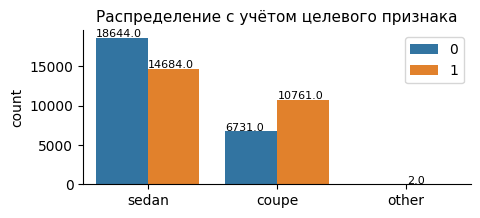

In [56]:
countplot('vehicle_type',5,2, legend_loc='upper right')

Машины с типом кузова 'coupe' чаще виновны в дтп, чем 'sedan'.

#### vehicle_transmission

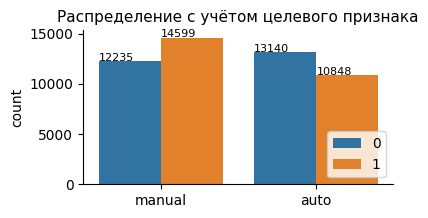

In [57]:
countplot('vehicle_transmission',4,2, legend_loc='lower right')

Машины с ручным переключением передач чаще виновны в дтп, чем машины с АКПП.

<a id= 'vehicle_age'></a>
#### vehicle_age	

In [58]:
def description(feature, legend_loc='best', range=(None,None)):
    '''По названию признака рисует диаграммы размаха, гистограммы и табличку с точными статистиками'''
    f, ax = plt.subplots(3,2, sharex=True, gridspec_kw={"height_ratios": (.15, .15, .70), 
                                                        "width_ratios": (0.85, 0.15)}, figsize=(9,5))
    sns.boxplot (x=data[feature][data['at_fault'] == 0], ax=ax[0,0])
    sns.boxplot (x=data[feature][data['at_fault'] == 1], ax=ax[1,0], color='orange')
    sns.histplot(x=data[feature][data['at_fault'] == 0], bins=100, ax=ax[2,0], element="step",alpha=0.3, legend = True)
    sns.histplot(x=data[feature][data['at_fault'] == 1], bins=100, ax=ax[2,0], element="step",alpha=0.3, color='orange')
    ax[0,1].remove(); ax[1,1].remove()
    table(data=data[feature].describe(), ax=ax[2,1], loc='right',colWidths=[1.8])
    
    ax[0,0].set(yticks=[], xlabel=None); ax[1,0].set(yticks=[], xlabel=None)
    ax[2,0].legend(['at_fault = 0', 'at_fault = 1'], loc=legend_loc)
    
    ax[0,0].set_xlim(range)
    
    sns.despine(ax=ax[2,0])
    sns.despine(ax=ax[0,0], left=True); sns.despine(ax=ax[1,0], left=True)
    plt.axis('off')

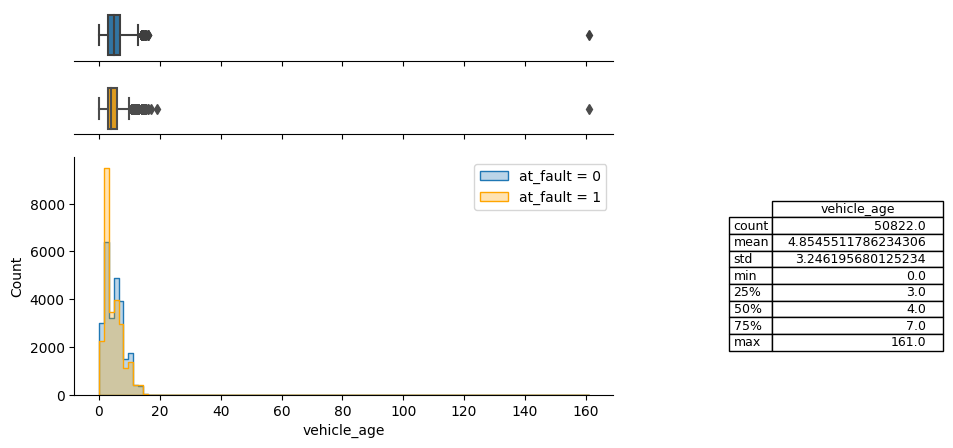

In [59]:
description('vehicle_age')

In [60]:
(data['vehicle_age']>30).sum()  # количество автомобилей с возрастом более 30 лет

2

In [61]:
data.drop(data[data['vehicle_age']>30].index, inplace=True) # удаляем 2 объекта с выбросами

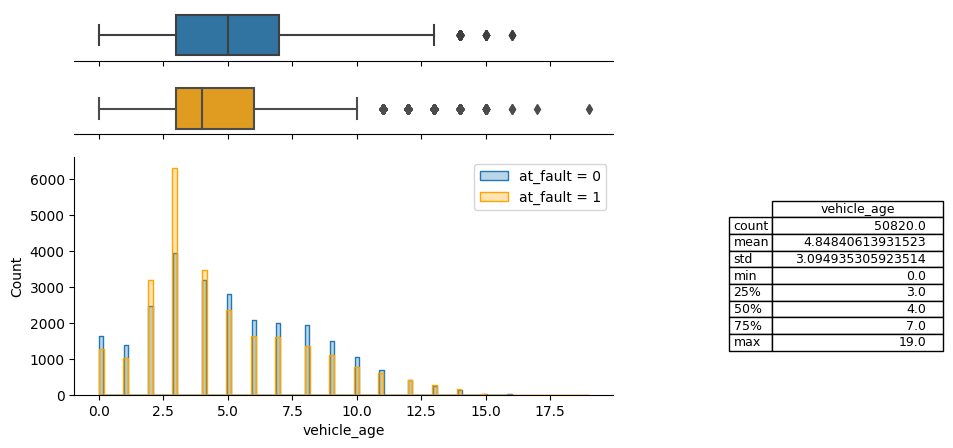

In [62]:
description('vehicle_age')

Чаще всего машины попадают в дтп возрастом 3 года. Медиана (без учёта целевого признака) - 4 года.\
Автомобили возрастом 2, 3, 4 года чаще виновны в дтп, чем автомобили других возрастов.

#### at_fault

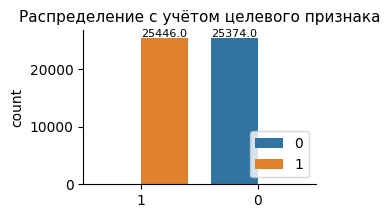

In [63]:
countplot('at_fault', 3, 2, legend_loc = 'lower right') # баланс классов

В датасете примерно равное количество автомобилей, которые виновны и невиновны в дтп.

#### insurance_premium

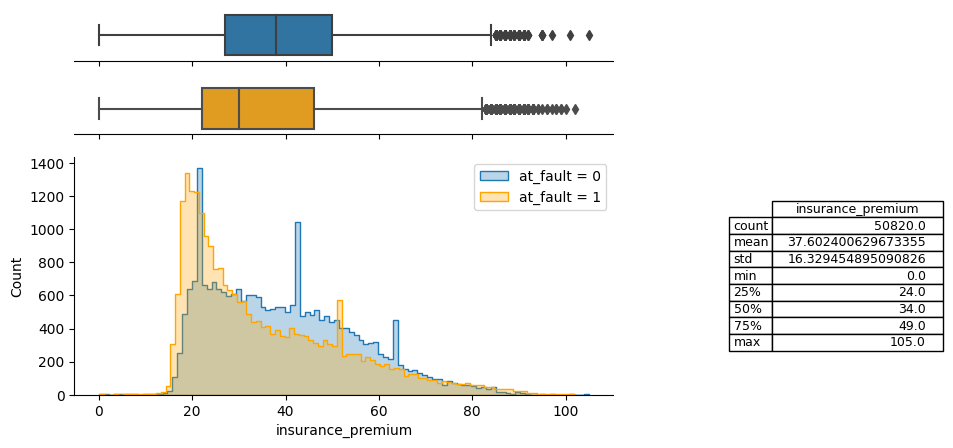

In [64]:
description('insurance_premium')

Автомобили с суммой страховки до \\$30 тыс., т.е. менее дорогие, чаще виновны в дтп.\
Автомобили с суммой страховки после \\$30 тыс., т.е более дорогие, реже виновны в дтп.

<a id= 'sobriety'></a>
#### party_sobriety

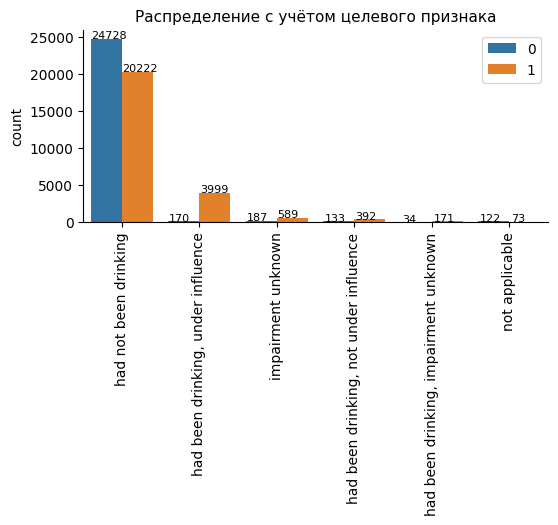

In [65]:
countplot('party_sobriety', 6, 2.5, xrotation=90)

Участники дтп в алкогольном опьянении значительно чаще являются виновниками аварии.\
Трезвые участники дтп реже виновны в аварии.

#### party_drug_physical

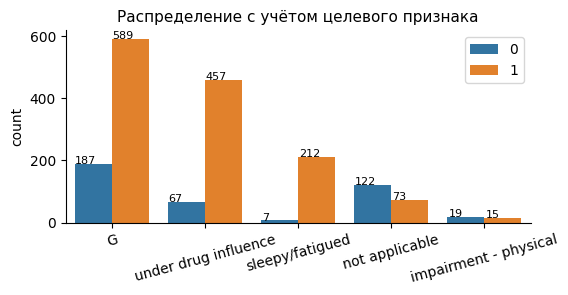

In [66]:
countplot('party_drug_physical', 6, 2.5, xrotation=15)

Ранее было установлено, что в признаке 95% пропусков. Скорее всего тест на употребление наркотиков не проводился (not applicable).

In [67]:
data['party_drug_physical'].fillna('not applicable', inplace=True) # заполнение пропусков 'not applicable'

In [68]:
data['party_drug_physical'].replace('G', 'impairment unknown', inplace=True) # замена "G" на полную расшифровку

Большинство участников аварии не проверялось на наркотики, что очевидно, так как проверка происходит при явном подозрении.\
Среди тех кого проверили, большинство были под влиянием наркотических веществ.

#### cellphone_in_use	

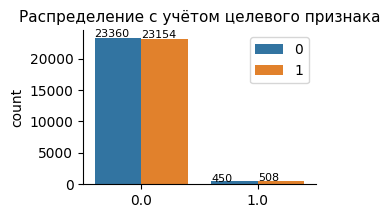

In [69]:
countplot('cellphone_in_use', 3, 2)

In [70]:
data['cellphone_in_use'].fillna(0, inplace=True) # 8% пропусков заполним, как авто без системы hands free (0)

В исходном описании задания этот признак характеризуется как устройство hands free.\
Кроме того, в 2012 году, полагаю, большинство машин уже была оборудована hands free.\
Судя по аналитике и по английскому названию, признак говорит общался ли водитель в момент аварии по телефону.\
Кто в этом признался, виновников аварии немного больше. Большинство не признаются.\
Для ML признак бесполезный.

#### county_city_location	

In [71]:
data['county_city_location'].apply(lambda x: type(x)).unique()  # присутствующие типы данных

array([<class 'str'>], dtype=object)

In [72]:
(~data['county_city_location'].str.isdigit()).sum()             # число county_city_location, в которых есть не цифры

0

In [73]:
data['county_city_location'] = data['case_id'].astype(int)      # перевод county_city_location в числовой формат

In [74]:
data['county_city_location'].nunique()                          # число уникальных значений

40737

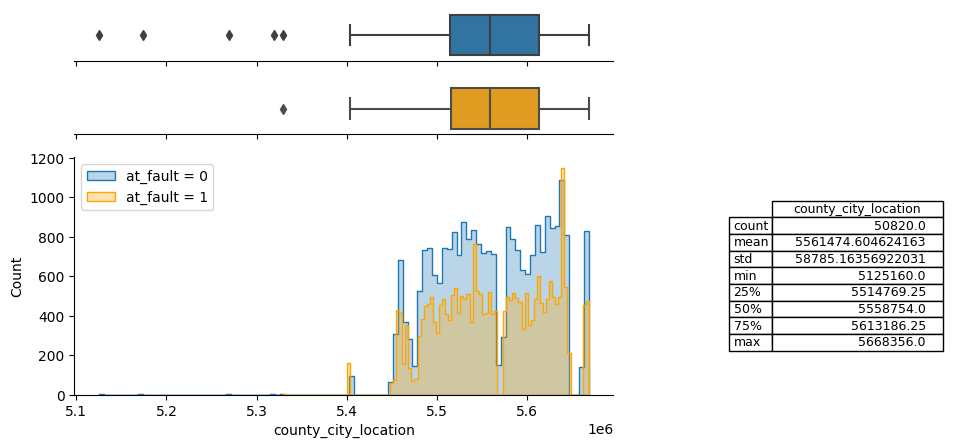

In [75]:
description('county_city_location', legend_loc='upper left')

* Число уникальных значений 40732 при размере датасета 50814. Признак слишком локализован (подразумевает небольшую территорию). Для ML признак фактичекси бесполезен.\
Чтобы признак был полезен в ML необходимо знать логику нумерации. Например, если в этих числах зашифрованы gps-координаты, можно было бы создать новый категориальный признак, разделяющий поверхность на более крупные сегменты.
* Во всех районах 'county_city_location' примерно одинаковое соотношение числа виновных к невиновным.
* Есть районы с бОльшим числом дтп, есть с меньшим. Вероятно, в главной мере зависит от трафика (больше машин - больше аварий).
* В данных около шести выбросов (районов), куда машины заезжают редко.

#### county_location

In [76]:
np.sort(data.county_location.unique()) # уникальные значения; проверка на неявные дубликаты

array(['alameda', 'alpine', 'amador', 'butte', 'calaveras', 'colusa',
       'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn',
       'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen',
       'los angeles', 'madera', 'marin', 'mariposa', 'mendocino',
       'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange',
       'placer', 'plumas', 'riverside', 'sacramento', 'san benito',
       'san bernardino', 'san diego', 'san francisco', 'san joaquin',
       'san luis obispo', 'san mateo', 'santa barbara', 'santa clara',
       'santa cruz', 'shasta', 'sierra', 'siskiyou', 'solano', 'sonoma',
       'stanislaus', 'sutter', 'tehama', 'trinity', 'tulare', 'tuolumne',
       'ventura', 'yolo', 'yuba'], dtype=object)

Неявных дубликатов нет.

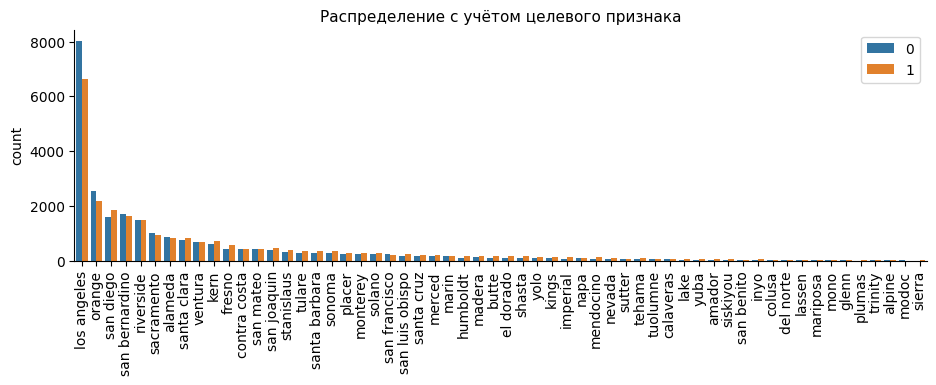

In [77]:
countplot('county_location', 11, 3, xrotation=90, annotation=False)

В округе Лос-Анджелес больше всего аварий. Вероятно из-за того, что это самый большой округ с наибольшим трафиком.

#### distance

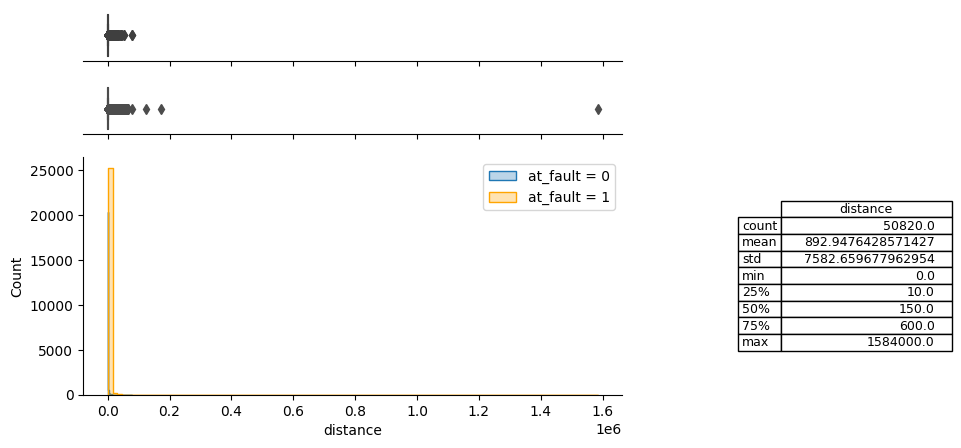

In [78]:
description('distance')

In [79]:
data.query('distance>75000').shape[0] # кол-во выбросов; дистанция больше 75 км

6

In [80]:
data.drop(data[data.distance>75000].index, inplace=True) # удаление выбросов

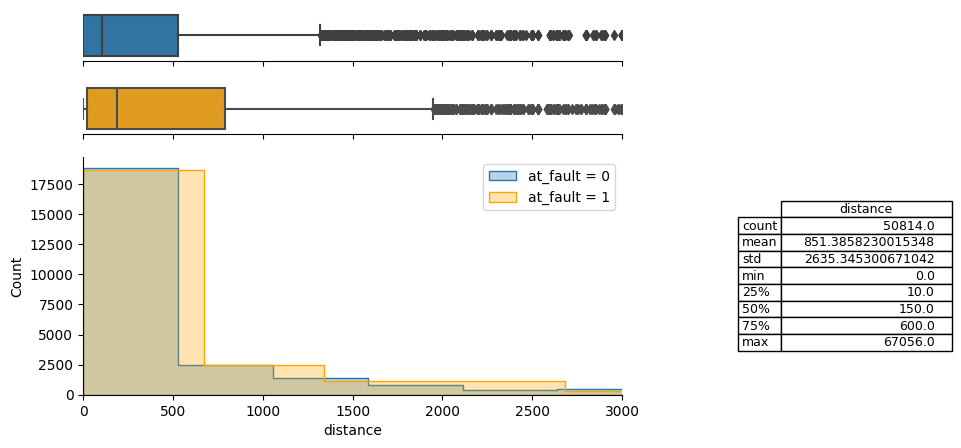

In [81]:
description('distance', range=(0,3000))

Непонятный признак. Небольшая зависимость в том, что чем дальше от главной дороги, тем больше нарушителей.

#### direction

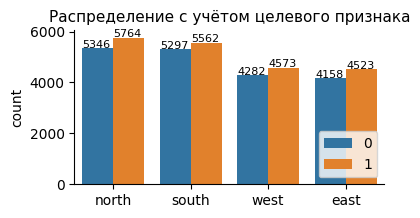

In [82]:
countplot('direction', 4, 2, legend_loc='lower right')

В вертикальном направлении (север - юг) аварий больше, чем в горизонтальном (запад - восток). Это было также продимонстрировано выше в [п.3.2](#north).
По всем направлениям соотношение виновен/невиновен примерно одинаковое.

В признаке 23% пропусков. Заполним их рандомно.

In [83]:
data.loc[data['direction'].isna(), 'direction'] =\
data.loc[data['direction'].isna(), 'direction'].apply(lambda _: random.choice(['north','west', 'south', 'east']))

#### weather_1

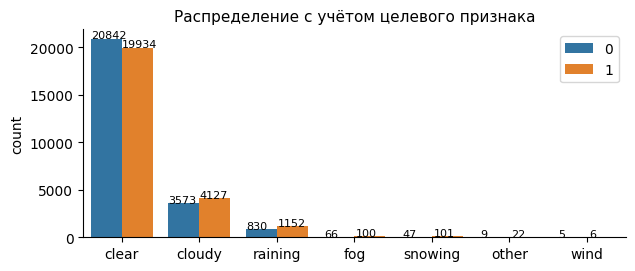

In [84]:
countplot('weather_1', 7, 2.7)

* В тяжёлые метеоусловия случаев, где водитель виновен в дтп больше; в хорошую погоду случаев с невиновными водителями немного больше.
* ДТП наиболее распространены в ясную погоду из-за того что ясная погода бывает чаще, чем сложные метеоусловия.

#### intersection	

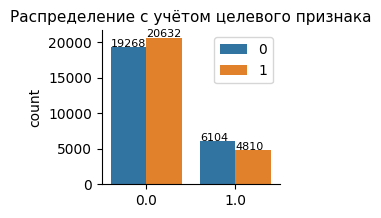

In [85]:
countplot('intersection', 2.3, 2)

* В авариях на перекрёстке чаще участник невиновен в дтп.
* Аварий на перекрёстках примерно в 4 раза меньше, чем в других локациях.

#### location_type

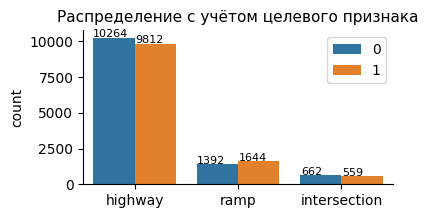

In [86]:
countplot('location_type', 4, 2)

В датасете 2 признака характеризующие была ли авария на перекрёстке: intersection, location_type.\
В location_type 54% пропусков. Заполним эти пропуски значением intersection, если в признаке intersection они так обозначены.

In [87]:
data.query('location_type.isna() & intersection == 1').shape[0] # кол-во пропусков, которые можно заполнить intersection

9345

In [88]:
data.loc[data['location_type'].isna() & data['intersection']==1, 'location_type'] = 'intersection'

In [89]:
data['location_type'].isna().mean().round(2)  # доля оставшихся пропусков после заполнения

0.34

In [90]:
data['location_type'].fillna('unknown', inplace=True) # заполнение оставшихся пропусков значением unknown

#### collision_damage

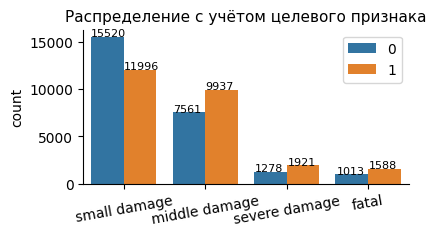

In [91]:
countplot('collision_damage', 4.2, 2, xrotation=10)

* При аварии наиболее частыми являются небольшие повреждения.
* При небольших повреждениях невиновных участников больше; при средних и крупных повреждениях участников виновных в дтп больше.

<a id= 'party_count'></a>
#### party_count

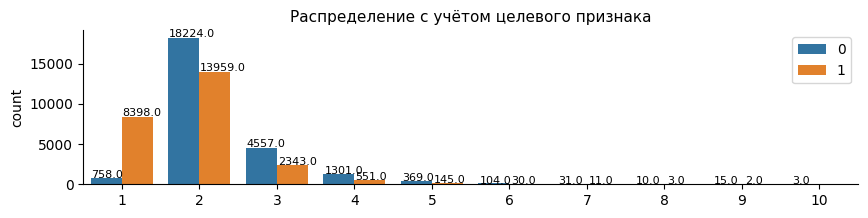

In [92]:
countplot('party_count', 10, 2, legend_loc='upper right', order = sorted(data['party_count'].unique().tolist()))

* Чаще всего дтп происходит между двумя участниками.
* Во всех случаях (кроме одного участника) виновных в аварии меньше чем невиновных.

#### primary_collision_factor	

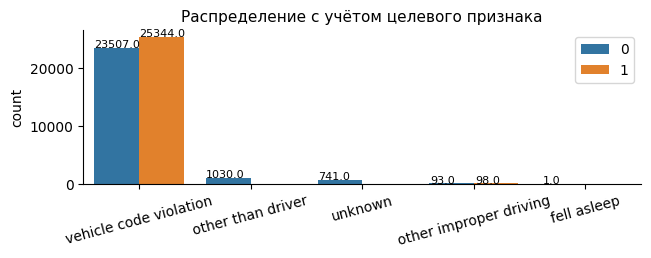

In [93]:
countplot('primary_collision_factor', 7.2, 2, xrotation = 15)

Причиной дтп чаще всего является нарушение ПДД.

#### pcf_violation_category

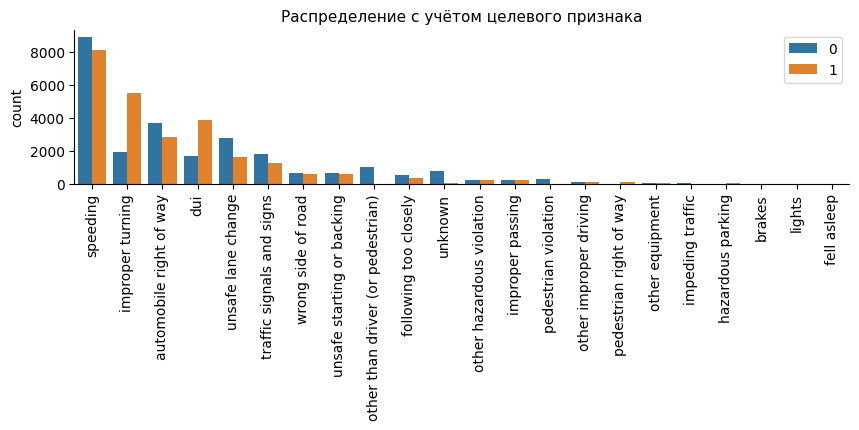

In [94]:
countplot('pcf_violation_category', 10, 2, xrotation = 90, annotation=False, legend_loc='upper right')

Наиболее частые причины дтп: скоростной режим, неправильный поворот, алкогольное/наркотическое опьянение, ошибка с очерёдностью проезда.

#### type_of_collision

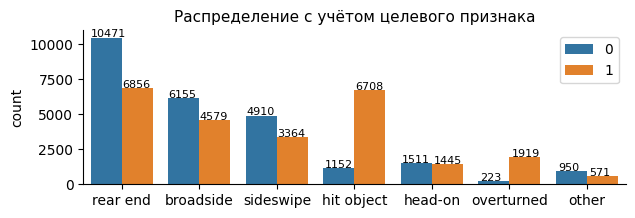

In [95]:
countplot('type_of_collision', 7, 2)

* Наиболее частый тип аварии - повреждение задней части автомобиля, боковой удар, выезд на обочину.
* В упомянутых выше случаях невиновных участников больше чем виновных.
* В ударе объекта (hit object) или в переворачивании авто (overturned), очевидно, что чаще виновен тот кто ударил/перевернулся.

#### motor_vehicle_involved_with

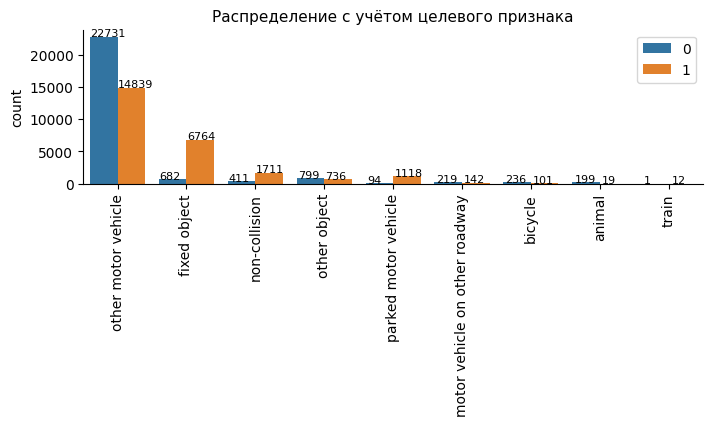

In [96]:
countplot('motor_vehicle_involved_with', 8, 2, xrotation=90)

Другой автомобиль - наиболее частый второй участник дтп.

#### road_surface

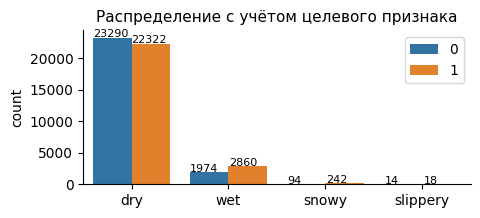

In [97]:
countplot('road_surface', 5, 2)

В большинстве случаев дорожное покрытие сухое.

#### road_condition_1

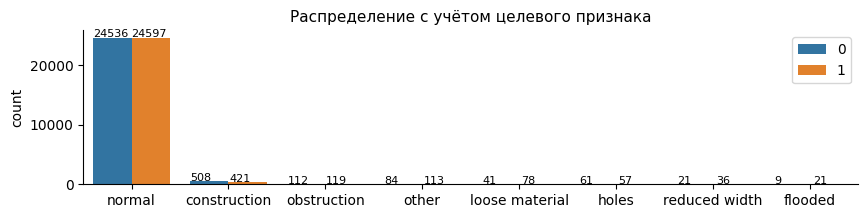

In [98]:
countplot('road_condition_1', 10, 2)

* В большинстве случаев дорожное состояние нормальное.
* Тип состояния дороги не влияет на виновность/невиновность.

#### lighting

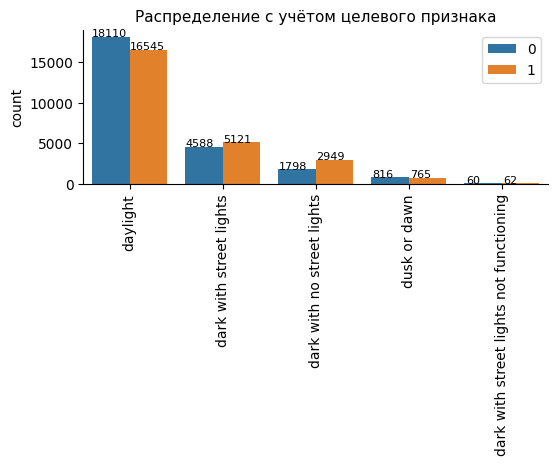

In [99]:
countplot('lighting', 6, 2, xrotation=90)

Больше всего аварий в дневное время суток при естевственном освещении.

#### control_device

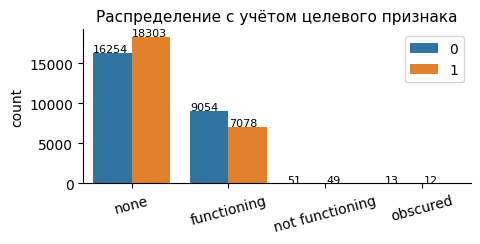

In [100]:
countplot('control_device', 5, 2, xrotation=15)

Я не знаю, что это за признак. Посмотрим позднее на его корреляцию с целевым и примем решение о целесообразности его использования в ML.

#### month

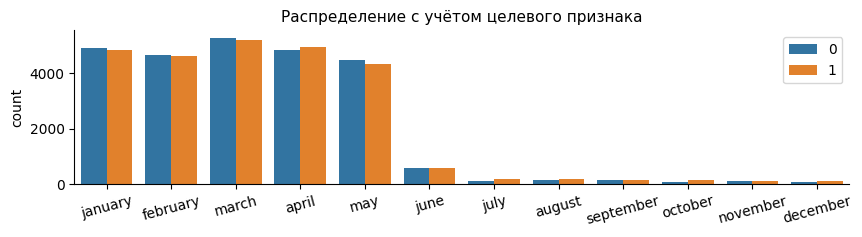

In [101]:
countplot('month', 10, 2, annotation=False, xrotation=15,
          order = ['january', 'february', 'march', 'april', 'may', 'june', 
                   'july', 'august', 'september', 'october', 'november', 'december'])

Согласно пожеланию заказчика была взята выборка только за 2012 год. Однако, по [распределению всего исходного датасета (п.3.1)](#month_distribution) видим, что полноценные данные содержатся только до апреля 2012г. (включая). Позднее зафиксированное число происшествий резко уменьшилось. Реальное число аварий не могло так резко сократиться в одной и той же локации. Поэтому присутствует техническая ошибка по фиксированию полного объёма данных.

В ML-модель признак 'month' не будет включён, так как он принесёт ошибочное представление о сезонности.\
**В нашей модели не будет учтена сезонность.**

Чтобы учесть сезонность необходимо взять данные с января 2011 до апреля 2012 (рекомендация Заказчику).
Сезонность аварийности видна на графике со среднемесячным числом аварий [выше на втором графике в п.3.1](#month_distribution), который построен без учёта подозрительно низких данных (май 2012 и позднее).

#### day_of_week

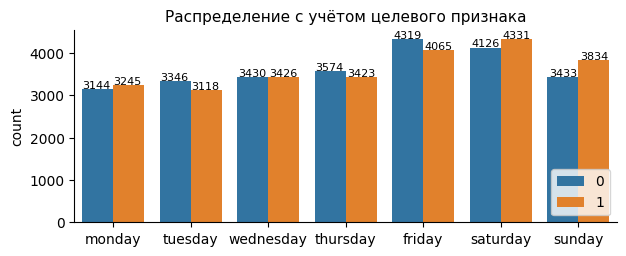

In [102]:
countplot('day_of_week', 7, 2.5, legend_loc='lower right',
          order = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'])

В пятницу и выходные дни число аварий возрастает на ~15%.\
Может быть связано, как с увеличенным трафиком, так и с тем что водители садятся за руль в алкогольном опьянении.

#### hour

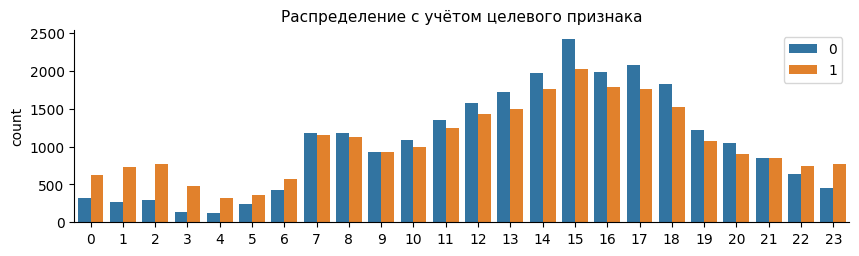

In [103]:
countplot('hour', 10, 2.5, annotation=False, order=range(0,24))

* Аварий больше в дневные часы, очевидно из-за большего трафика.
* В ночные часы больше зафиксированных случаев, где авария произошла по вине участника случая; в дневные - наоборот (невиновных больше).

#### Корректировка типа данных

Для уменьшения занимаемой памяти, и как следствие увеличение быстродействия, изменим тип данных у нескольких признаков.\
Ранее не могли трансформировать из-за наличия пропусков.

In [104]:
data[['vehicle_age', 'insurance_premium', 'cellphone_in_use', 'distance', 'intersection', 'hour']]=\
data[['vehicle_age', 'insurance_premium', 'cellphone_in_use', 'distance', 'intersection', 'hour']].astype('int')

### Корреляция признаков 
<a id= 'corr'></a>

In [105]:
data.drop(['case_id', 'party_number'], axis=1, inplace=True) # удаляем признаки, которые точно не понадобятся в ML

In [106]:
# сортируем признаки по нескольким группам
data = data.reindex(columns=[
    
    # целевой признак
    'at_fault',
    
    # признаки известные перед поездкой
    'vehicle_type', 'vehicle_transmission', 'vehicle_age', 'insurance_premium', 'cellphone_in_use', 'county_city_location', 
    'county_location', 'distance', 'direction', 'intersection', 'weather_1', 'location_type', 'road_surface', 
    'lighting', 'control_device', 'month', 'day_of_week', 'hour',
    
    # признак, который можно узнать перед поездкой при установке в машину алкотестера и доп. аналитике
    'party_sobriety', 'road_condition_1',
    
    # признаки, которые можно выяснить только после аварии
    'party_drug_physical', 'collision_damage', 'party_count', 'primary_collision_factor', 'pcf_violation_category',
    'type_of_collision', 'motor_vehicle_involved_with'])

In [107]:
%%time
# формируем корреляционную Phi_K матрицу
phik_corr = data.phik_matrix(interval_cols=['vehicle_age', 'insurance_premium', 'distance', 'party_count'])

C:\Anaconda3\envs\ds_practicum_env\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable county_city_location is large: 40732. Are you sure this is not an interval variable? Analysis for pairs of variables including county_city_location can be slow.
  warnings.warn(


CPU times: total: 11.4 s
Wall time: 35.1 s


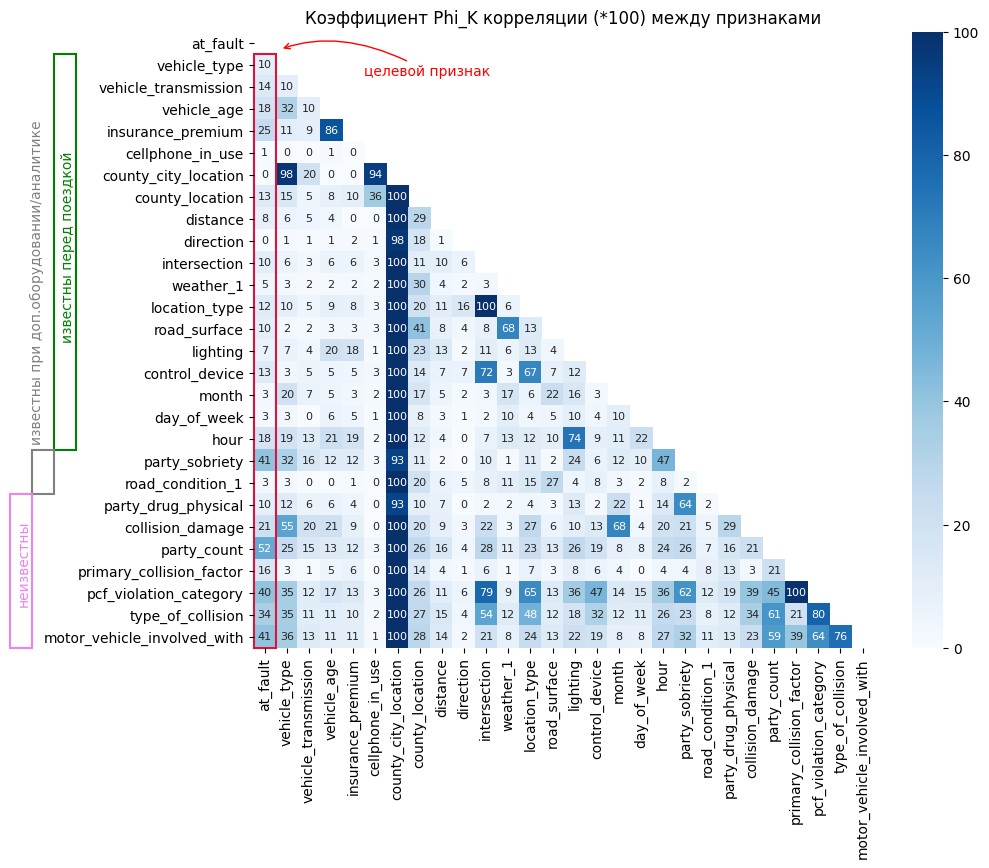

In [108]:
matrix = np.tri(len(phik_corr)).T
plt.figure(figsize=(10,8))
ax=sns.heatmap(phik_corr*100, cmap='Blues', mask=matrix, annot=True, fmt='.0f', annot_kws={"size":8})
plt.title('Коэффициент Phi_K корреляции (*100) между признаками')

# цветные прямоугольники для выделения, комментарии, стрелка
ax.add_patch(Rectangle(( 0, 1), 1, 27, fill=False, edgecolor='crimson', lw=1.5, clip_on=False))
ax.add_patch(Rectangle((-9, 1), 1, 18, fill=False, edgecolor='green', lw=1.5, clip_on=False))
ax.add_patch(Rectangle((-10, 19), 1, 2, fill=False, edgecolor='grey', lw=1.5, clip_on=False))
ax.add_patch(Rectangle((-11, 21), 1, 7, fill=False, edgecolor='violet', lw=1.5, clip_on=False))
ax.text(-8.7, 14, 'известны перед поездкой', color='green', rotation=90)
ax.text(-10.1, 18.6, 'известны при доп.оборудовании/аналитике', color='grey', rotation=90)
ax.text(-10.7, 26, 'неизвестны', color='violet', rotation=90)
ax.annotate('целевой признак', xy=(1.2, 0.8), xytext=(5, 2), color='red',
            arrowprops=dict(arrowstyle="->", connectionstyle="angle3, angleA=-30, angleB=20", color = 'red'))
plt.show()

<a id= 'data'></a>
### Вывод по анализу данных

Главное:
* в ML берём следующие признаки: 'vehicle_type', 'vehicle_transmission', 'vehicle_age', 
    'county_location', 'distance', 'weather_1', 'location_type', 'road_surface', 
    'lighting', 'control_device', 'day_of_week', 'hour', 'party_sobriety'.

Комментарий по главному и по табице корреляции:

*  'insurance_premium' и 'vehicle_age' в мультиколлинеарной зависимости; заказчик просил учесть именно 'vehicle_age', поэтому 'insurance_premium' в ML не берём;
* 'county_city_location' - признак обязательно необходимый для доработанной итоговой версии модели, в которой будет понятна логика этого признака, его привязка к конкретным участкам карты; на сегодняшнем этапе разработки признак мультиколлинеарен практичекси ко всем из-за своей гиперуникальности (число уникальных значений признака ненамного меньше числа рассматриваемых случаев); сейчас в работу не берём;
* 'intersection' входит в состав 'location type' поэтому берём только 'location type';
* 'party_sobriety' - может быть использован, если установить в машины алкотестер (подразумеваем, что он есть);
* 'road_condition_1' - признак может быть использован, если будет система он-лайн аналитики дорог (аварии, затопление); это может быть в кооперации с другими картографическими он-лайн сервисами (сейчас подразумеваем, что его нет).

Подробнее:

* база данных представлена одной схемой с четырьмя таблицами, описывающими произошедшие дтп за период с января 2009г. по июль 2020г.;
* начиная с мая 2012г. данные подозрительно резко уменьшаются (вероятно, техническая ошибка);
* наибольшее количество аварий в осенне-зимние месяцы с сентября по декабрь (в ML сезонность не учтена из-за пожелания заказчика рассматривать только 2012г., в котором данные неполные; при следующей попытке изготовить модель необходимо учесть сезонность и взять данные с начала 2011г.);
* больше всего происшествий с купе и седанами, скорее всего, из-за того, что их больше в эксплуатации;
* в машинах с ручной коробкой передач реже установлено оборудование hands free;
* более новые автомобили чаще попадают в аварии по причине превышения скорости;
* нарушения связанные с правом проезда, езды в алкогольном опьянении и неправильным поворотом чаще присущи более новым автомобилям;
* всплеск аварийного вождения из-за алкогольного опьянения приходится на вечернее и ночное время суток: с 18:00 до 3 ночи; пик в 2 ночи;
* больше всего аварий по причине сонливости или усталости водителя в летние месяцы;
* аварий при "вертикальном" движении (север/юг) на 20% больше числа аварий в "горизонтальном" (запад/восток) движении; 
скорее всего связано с тем, что вертикальный трафик больше горизонтального;
* для ML загружено 56248 происшествий (2012г., автомобили, без учёта царапин);
* удалено около 10% объектов с пропусками;
* машины с типом кузова 'coupe' чаще виновны в дтп, чем 'sedan';
* машины с ручным переключением передач чаще виновны в дтп, чем машины с АКПП;
* чаще всего машины попадают в дтп возрастом 3 года; медиана - 4 года; автомобили возрастом 2, 3, 4 года чаще виновны в дтп, чем автомобили других возрастов;
* в датасете примерно равное количество автомобилей, которые виновны и невиновны в дтп;
* автомобили с суммой страховки до \\$30 тыс., т.е. менее дорогие, чаще виновны в дтп;
* участники дтп в алкогольном опьянении значительно чаще являются виновниками аварии;
* большинство участников аварии не проверялось на наркотики, что очевидно, так как проверка происходит при явном подозрении;
среди тех кого проверили, большинство были под влиянием наркотических веществ;
* в округе Лос-Анджелес больше всего аварий; вероятно из-за того, что это самый большой округ с наибольшим трафиком;
* в тяжёлые метеоусловия случаев, где водитель виновен в дтп больше; в хорошую погоду случаев с невиновными водителями немного больше;
* в авариях на перекрёстке чаще участник невиновен в дтп; аварий на перекрёстках примерно в 4 раза меньше, чем в других локациях;
* при аварии наиболее частыми являются небольшие повреждения; при небольших повреждениях невиновных участников больше; при средних и крупных повреждениях участников виновных в дтп больше;
* чаще всего дтп происходит между двумя участниками;
* причиной дтп чаще всего является нарушение ПДД:  скоростной режим, неправильный поворот, алкогольное/наркотическое опьянение, ошибка с очерёдностью проезда;
* наиболее частый тип аварии - повреждение задней части автомобиля, боковой удар, выезд на обочину; в упомянутых выше случаях невиновных участников больше чем виновных;
* в большинстве случаев дорожное покрытие сухое; дорожные условия нормальные;
* больше всего аварий в дневное время суток при естевственном освещении, из-за большего трафика в это время;
* в пятницу и выходные дни число аварий возрастает на ~15%;
* в ночные часы больше зафиксированных случаев, где авария произошла по вине участника случая; в дневные - наоборот (невиновных больше).

## Machine learning

### разбиение, нормализация, кодирование

In [109]:
# разбиение df на признаки и целевой признак
X = data[['vehicle_type', 'vehicle_transmission', 'vehicle_age', 'county_location', 'distance', 'weather_1', 
          'location_type', 'road_surface', 'lighting', 'control_device', 'day_of_week', 'hour', 'party_sobriety']]
Y = data['at_fault']

# разбиение df на обучающую и тестовую выборки (75/25); стратификацию не делаем, т.к. нет дисбаланса
X_train_, X_test_, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

# проверка полученной размерности
print(X_train_.shape, Y_train.shape)
print(X_test_.shape, Y_test.shape)

(38110, 13) (38110,)
(12704, 13) (12704,)


In [110]:
feature_num = ['vehicle_age', 'distance']
feature_cat = ['vehicle_type', 'vehicle_transmission', 'county_location', 'weather_1', 'location_type', 
               'road_surface', 'lighting', 'control_device', 'day_of_week', 'hour', 'party_sobriety']

In [111]:
# нормализация количественных признаков
scaler = StandardScaler()
scaler.fit(X_train_[feature_num])

X_train_scaled = scaler.transform(X_train_[feature_num])
X_test_scaled  = scaler.transform(X_test_[feature_num])

In [112]:
# OHE категориальных признаков
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder.fit(X_train_[feature_cat])

X_train_ohe = encoder.transform(X_train_[feature_cat]).toarray()
X_test_ohe  = encoder.transform(X_test_[feature_cat]).toarray()

In [113]:
# объединение обработанных количественных и категориальных признаков
X_train = np.concatenate([X_train_scaled, X_train_ohe], axis=1)
X_test  = np.concatenate([X_test_scaled,  X_test_ohe],  axis=1)

# проверка полученной размерности
print(X_train.shape)
print(X_test.shape)

(38110, 115)
(12704, 115)


In [114]:
# признаки для CatBoost (без кодировки категориальных; только нормализация числовых)
X_train_boost = pd.DataFrame(X_train_scaled, X_train_.index, feature_num).join(X_train_[feature_cat])
X_test_boost  = pd.DataFrame(X_test_scaled,  X_test_.index,  feature_num).join(X_test_[feature_cat])

**Выбор метрики качества - F1-мера**

Можно было бы выбрать даже accuracy, так как нет дисбаланса классов.
Нам необходимо сохранить баланс между recall и precission.\
Если бы нашей задачей было предсказать только фатальные случаи, тогда за метрику следовала бы принять recall, чтобы предельно избежать этих тяжёлых несчастных случаев (даже в ущерб precission).\
Но, так как за целевой признак принимается виновность в произошедшем при любой тяжести последствий (в т.ч. лёгкой), нам не надо быть слишком подозрительными чтобы почти всегда отправлять клиента по более безопасному маршруту. В этом случае увеличится пробег, стоимость обслуживания, выбросы CO и конечная цена для Заказчика. Это приведёт к стагнации бизнеса и проигрышу конкурентам.

### DummyClassifier

In [115]:
# определение F1 при случайном выборе ответа; вероятность классов 50/50
model = DummyClassifier(strategy="uniform", random_state=12345)
cross_val_score(model, X_train, Y_train, scoring='f1', cv=3).mean().round(4)

0.5002

### LogisticRegression

In [116]:
%%time
model=LogisticRegression()
parametrs={'solver':       ['lbfgs','liblinear','newton-cg', 'newton-cholesky', 'sag'],
           'max_iter':     [1000],
           'random_state': [12345]}
grid=GridSearchCV(estimator=model, param_grid=parametrs, scoring='f1', cv=3)
grid.fit(X_train, Y_train)

CPU times: total: 30.9 s
Wall time: 26.7 s


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'max_iter': [1000], 'random_state': [12345],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag']},
             scoring='f1')

In [117]:
grid.best_score_.round(4)

0.5803

In [118]:
grid.best_params_

{'max_iter': 1000, 'random_state': 12345, 'solver': 'lbfgs'}

### DecisionTreeClassifier

In [119]:
%%time
model=DecisionTreeClassifier()
parametrs={'criterion':        ['gini', 'entropy', 'log_loss'],
           'max_depth':        range(1,20),
           'min_samples_leaf': [1,3,5],
           'random_state':     [12345]}
grid=GridSearchCV(estimator=model, param_grid=parametrs, scoring='f1', cv=3)
grid.fit(X_train, Y_train)

CPU times: total: 1min 34s
Wall time: 1min 34s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': [1, 3, 5],
                         'random_state': [12345]},
             scoring='f1')

In [120]:
grid.best_score_.round(4)

0.6103

In [121]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'random_state': 12345}

### RandomForestClassifier

In [122]:
%%time
model=RandomForestClassifier()
parametrs={'criterion':        ['gini'],
           'max_depth':        range(2,25),
           'n_estimators':     range(80,201,20),
           'min_samples_leaf': [1,3,5],
           'random_state':     [12345]}
grid=RandomizedSearchCV(estimator=model, param_distributions=parametrs, scoring='f1', cv=3, random_state = 12345, n_iter=20)
grid.fit(X_train, Y_train)

CPU times: total: 2min 8s
Wall time: 2min 8s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': range(2, 25),
                                        'min_samples_leaf': [1, 3, 5],
                                        'n_estimators': range(80, 201, 20),
                                        'random_state': [12345]},
                   random_state=12345, scoring='f1')

In [123]:
grid.best_score_.round(4)

0.579

In [124]:
grid.best_params_

{'random_state': 12345,
 'n_estimators': 140,
 'min_samples_leaf': 5,
 'max_depth': 20,
 'criterion': 'gini'}

**Сокращение диапазона поиска**

In [125]:
%%time
model=RandomForestClassifier()
parametrs={'criterion':        ['gini'],
           'max_depth':        range(16,23),
           'n_estimators':     range(140,181,20),
           'min_samples_leaf': [3,5],
           'random_state':     [12345]}
grid=RandomizedSearchCV(estimator=model, param_distributions=parametrs, scoring='f1', cv=3, random_state = 12345, n_iter=10)
grid.fit(X_train, Y_train)

CPU times: total: 1min 48s
Wall time: 1min 48s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': range(16, 23),
                                        'min_samples_leaf': [3, 5],
                                        'n_estimators': range(140, 181, 20),
                                        'random_state': [12345]},
                   random_state=12345, scoring='f1')

In [126]:
grid.best_score_.round(4)

0.5809

In [127]:
grid.best_params_

{'random_state': 12345,
 'n_estimators': 180,
 'min_samples_leaf': 3,
 'max_depth': 21,
 'criterion': 'gini'}

**Сокращение дипазона поиска (2)**

In [128]:
%%time
model=RandomForestClassifier()
parametrs={'criterion':        ['gini'],
           'max_depth':        range(20,23),
           'n_estimators':     range(170,191,10),
           'min_samples_leaf': [3],
           'random_state':     [12345]}
grid=GridSearchCV(estimator=model, param_grid=parametrs, scoring='f1', cv=3)
grid.fit(X_train, Y_train)

CPU times: total: 1min 55s
Wall time: 1min 55s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(20, 23),
                         'min_samples_leaf': [3],
                         'n_estimators': range(170, 191, 10),
                         'random_state': [12345]},
             scoring='f1')

In [129]:
grid.best_score_.round(4)

0.5813

In [130]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 21,
 'min_samples_leaf': 3,
 'n_estimators': 170,
 'random_state': 12345}

### LightGBM

In [131]:
def f1_metric(preds, train_data):
    '''рассчёт F1, т.к. в LightGBM нет такой метрики'''
    labels = train_data.get_label()
    return 'f1', f1_score(labels, preds.round()), True

def lightgbm(iterations = 1000, learning_rate = 0.1, depth = 2):
    '''возвращает максимальное F1 и номер итерации, на которой метрика была получена'''
    
    train_data = lgb.Dataset(X_train, Y_train)
    
    param = {'objective':            'binary',
             'metric':               'binary_logloss',
             'learning_rate':        learning_rate,
             'max_depth':            depth,
             'num_leaves':           1000,
             'early_stopping_round': 10,
             'verbose':              -1,
             'random_state':         123}
    
    scores = pd.DataFrame(lgb.cv(param, 
                                 train_data, 
                                 nfold=3,
                                 feval=f1_metric,
                                 num_boost_round=iterations))
    
    return scores['f1-mean'].idxmax(), scores['f1-mean'].max().round(4)

In [132]:
%%time
# перебор depth и learining_rate для расчёта F1: формируется отсортированный df с результатами
df_lightgbm = pd.DataFrame(columns=['depth', 'learining_rate', 'iteration', 'F1'])
for depth in range(2,14,2):
    for learining_rate in [0.1, 0.01]:
        result = lightgbm(depth = depth, learning_rate = learining_rate)
        df_lightgbm = pd.concat([df_lightgbm, pd.DataFrame([[depth, learining_rate, result[0], result[1]]],
                                                           columns=['depth', 'learining_rate', 'iteration', 'F1'])])
df_lightgbm = df_lightgbm.sort_values('F1', ascending=False).reset_index(drop=True)

CPU times: total: 16.5 s
Wall time: 11.1 s


In [133]:
df_lightgbm # параметры и метрика F1, отсортированная по убыванию

,depth,learining_rate,iteration,F1
0,4,0.01,0,0.6035
1,8,0.10,3,0.6017
2,8,0.01,13,0.6009
3,10,0.01,2,0.5958
4,12,0.10,4,0.5953
5,10,0.10,5,0.5943
6,12,0.01,5,0.5924
7,6,0.10,13,0.5913
8,6,0.01,16,0.5881
9,4,0.10,1,0.5712


### CatBoost

In [134]:
def catboost(iterations = 1000, learning_rate = 0.1, depth = 2):
    '''возвращает максимальное F1 и номер итерации, на которой метрика была получена'''
    cv_dataset = Pool(data         = X_train_boost,
                      label        = Y_train,
                      cat_features = feature_cat)

    params = {"iterations":            iterations,
              "early_stopping_rounds": 10,
              "learning_rate":         learning_rate,
              "depth":                 depth,
              "loss_function":         'Logloss',
              "logging_level":         'Silent',
              "eval_metric":           'F1',
              "random_state":          125}

    scores = cv(cv_dataset,
                params,
                fold_count=3,
                shuffle=False)
    
    return scores['test-F1-mean'].idxmax(), scores['test-F1-mean'].max().round(4)

In [135]:
%%time
# перебор depth и learining_rate для расчёта F1: формируется отсортированный df с результатами
df_catboost = pd.DataFrame(columns=['depth', 'learining_rate', 'iteration', 'F1'])
for depth in range(2,14,2):
    for learining_rate in [0.1, 0.01]:
        result = catboost(depth = depth, learning_rate = learining_rate)
        df_catboost = pd.concat([df_catboost, pd.DataFrame([[depth, learining_rate, result[0], result[1]]],
                                                           columns=['depth', 'learining_rate', 'iteration', 'F1'])])
df_catboost = df_catboost.sort_values('F1', ascending=False).reset_index(drop=True)

CPU times: total: 14min 36s
Wall time: 2min 38s


In [136]:
df_catboost # параметры и метрика F1, отсортированная по убыванию

,depth,learining_rate,iteration,F1
0,8,0.10,108,0.5879
1,10,0.10,74,0.5821
2,12,0.10,127,0.5815
3,6,0.10,108,0.5797
4,4,0.10,138,0.5775
5,10,0.01,4,0.5619
6,2,0.10,0,0.5617
7,2,0.01,0,0.5617
8,12,0.01,15,0.5617
9,6,0.01,0,0.5592


<a id= 'pivot'></a>
### Сводная таблица

| Algorithm | Parameters | F1 |
| --- | --- | --- |
| DummyClassifier | uniform | 0.5002 |
| LogisticRegression | 'max_iter': 1000, 'random_state': 12345, 'solver': 'lbfgs' | 0.5803 |
| DecisionTreeClassifier | 'criterion': 'gini',  'max_depth': 6, 'min_samples_leaf': 3, 'random_state': 12345 | 0.6103 |
| RandomForestClassifier | 'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 3, 'n_estimators': 170, 'random_state': 12345 | 0.5813 |
| LightGBM | 'n_estimators': 0, 'learning_rate': 0.01, 'max_depth': 4,<br> 'num_leaves': 1000, 'early_stopping_round': 10, 'random_state': 123, nfold=3 | 0.6035 |
| CatBoost | "iterations": 108, "learning_rate": 0.1, "depth": 8,<br> "random_state": 125, fold_count=3, shuffle=False | 0.5879 |

Лучший результат у модели DecisionTreeClassifier.

## Проверка лучшей модели

Проверка выбранной лучшей модели DecisionTreeClassifier на тестовой выборке.

In [137]:
model=DecisionTreeClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 3, random_state = 12345)

model.fit(X_train, Y_train)
Y_test_prediction = model.predict(X_test)
f1_score(Y_test, Y_test_prediction).round(4)

0.6197

### Precision, Recall, ROC, ConfusionMatrix

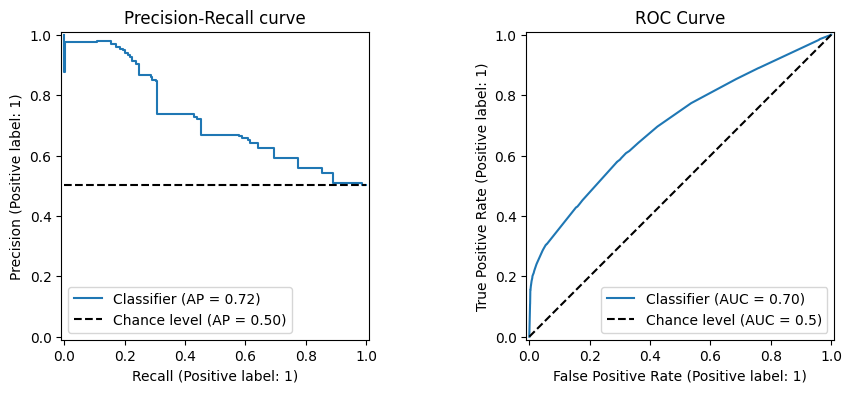

In [138]:
f, ax = plt.subplots(1,2,figsize=(11,4))
probabilities_test = model.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(Y_test, probabilities_test, plot_chance_level=True, ax=ax[0])
RocCurveDisplay.from_predictions(Y_test, probabilities_test, plot_chance_level=True, ax=ax[1])
ax[0].set_title("Precision-Recall curve"); ax[1].set_title("ROC Curve"); plt.show()

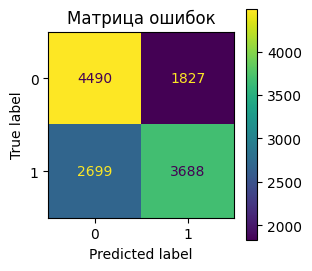

In [139]:
f, ax = plt.subplots(figsize=(3,3))
ConfusionMatrixDisplay.from_predictions(Y_test,Y_test_prediction, ax=ax)
plt.title('Матрица ошибок'); plt.show()

### Feature importance

In [140]:
def collapse_list(importances_ohe, features):
    '''сокращаяет размер Series, суммируя значения схожих индексов; список уникальных индексов передаётся вторым аргументом'''
    importances = []
    for f in features:
        importances.append(importances_ohe[list(map(bool,importances_ohe.index.str.find(f)+1))].sum())
    return pd.Series(importances, features).sort_values(ascending=False)

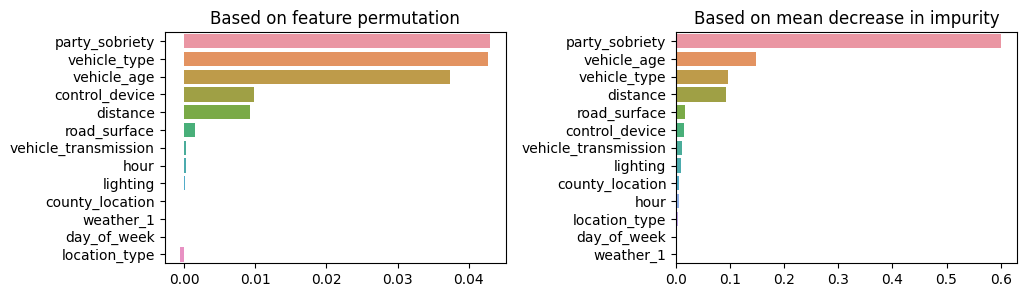

In [141]:
f, (ax_1, ax_2) = plt.subplots(1,2,figsize=(11,3),gridspec_kw={"wspace": 0.5})

result_1 = permutation_importance(model, X_test, Y_test, random_state=42)
importances_1 = pd.Series(result_1.importances_mean, index=feature_num+encoder.get_feature_names_out().tolist())
importances_1 = collapse_list(importances_1,X.columns)
sns.barplot(x = importances_1.sort_values(ascending=False),
            y = importances_1.sort_values(ascending=False).index, ax=ax_1).set(title='Based on feature permutation')

importances_2 = model.feature_importances_
importances_2 = pd.Series(importances_2, index=feature_num+encoder.get_feature_names_out().tolist())
importances_2 = collapse_list(importances_2,X.columns)
sns.barplot(x=importances_2.sort_values(ascending=False),
                     y=importances_2.sort_values(ascending=False).index, ax=ax_2).set(
                     title='Based on mean decrease in impurity'); plt.show()

Признаки больше всего влияющие на результат работы модели:
* party_sobriety; аналитика выше в [п.4.2.9](#sobriety);
* vehicle_type; аналитика выше в [п.4.2.4](#vehicle_type);
* vehicle_age;  аналитика выше в [п.4.2.6](#vehicle_age).

## Вывод

Главное:
* по существующему набору данных невозможно сделать модель, которая предсказывает вероятность дтп и предлагает альтернативный безопасный маршрут;
* скорее всего, модель реализуема при сборе дополнительной информации, агрегации с иными on-line сервисами, установке специального оборудования в автомобиль.

Подробнее:
* из полученного датасета для модели были отобраны признаки, которые возможно получить перед поездкой (в т.ч. подразумеваем наличие встроенного алкотестера); другие признаки, собираемые по факту аварии мы не можем использовать в модели;\
подробный вывод по аналитике исходных данных в [п.4.4](#data).
* построено 6 моделей:\
DummyClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LightGBM, CatBoost ([сводная таблица в п.5.8](#pivot));\
лучшую метрику качества показал DecisionTreeClassifier	(F1 = 0.6197 на тестовой выборке);
* полученная максимальная метрика качества не намного выше предсказания случайной модели DummyClassifier (~0.5);
* предсказание в основном полагается на три метрики, которые не характеризуют маршрут (party_sobriety, vehicle_type, vehicle_age).

Необходимо для построения модели:
* признак геолокации; в исходном датасете есть два признака, характеризующие географическое положение, но они не применимы; county_location - слишком общий (очень крупные географические пространства);\
county_city_location - слишком детализировано и нет понимания по логике привязки к карте; т.е. county_city_location можно применить, проведя его категоризацию - сделать более крупные участки (например, квартал); требуется карта для корректной категоризации;
* логика построения модели следующая; строится трек из точки А в точку B; видно через какие локации проходит трек (категоризированный county_city_location); каждая локация имеет свой риск аварии в зависимости от времени, погоды и др.; модель определит суммарный риск через все локации трека, и если риск выше какого-то порога, будет искать другой трек;
* авария зависит от трёх факторов: квалификация водителя, техническое состояние автомобиля, уровень безопасности маршрута;\
в модель необходимо добавить информацию о водителе; это может быть к-нт безаварийного вождения (известный по ОСАГО) или исторические данные конкретно этой каршеринговой компании;\
желательно скооперироваться с другими on-line сервисами, мониторящими дорожную ситуацию (пробки, аварии, ремонтные работы);
* для недопуска в машину водителя в алкогольном опьянении возможно установить алкотестер (в построеных моделях подразумеваем, что он уже есть);
* все выше прописанные рекомендации имеют смысл при экономической окупаемости их внедрения (вопрос требует более глубокой проработки).